# Exercise 4: Logistic Regression, Bayes and EM

In this assignment you will implement several algorithms as learned in class.

## Read the following instructions carefully:

1. This jupyter notebook contains all the step by step instructions needed for this exercise.
2. Write **efficient vectorized** code whenever possible. Some calculations in this exercise take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deduction.
3. You are responsible for the correctness of your code and should add as many tests as you see fit. Tests will not be graded nor checked.
4. Write your functions in this notebook only. **Do not create Python modules and import them**.
5. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only. **Do not import anything else.**
6. Your code must run without errors. During the environment setup, you were given a specific version of `numpy` to install (1.15.4). Changes of the configuration we provided are at your own risk. Any code that cannot run will not be graded.
7. Write your own code. Cheating will not be tolerated.
8. Submission includes this notebook only with the exercise number and your ID as the filename. For example: `hw4_123456789_987654321.ipynb` if you submitted in pairs and `hw4_123456789.ipynb` if you submitted the exercise alone.
9. Answers to qualitative questions should be written in **markdown** cells (with $\LaTeX$ support). Answers that will be written in commented code blocks will not be checked.

## In this exercise you will perform the following:
1. Implement Logistic Regression algorithm.
1. Implement EM algorithm.
1. Implement Navie Bayes algorithm that uses EM for calculating the likelihood.
1. Visualize your results.

# I have read and understood the instructions: *** 300420379_301833836 ***

In [34]:
import numpy as np
import pandas as pd
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload 2
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
# Function for ploting the decision boundaries of a model
# You will use it later
def plot_decision_regions(X, y, classifier, resolution=0.01):

    # setup marker generator and color map
    markers = ('.', '.')
    colors = ('blue', 'red')
    cmap = ListedColormap(colors[:len(np.unique(y))])
    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

## Reading the data

In [36]:
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
X_training, y_training = training_set[['x1', 'x2']].values, training_set['y'].values
X_test, y_test = test_set[['x1', 'x2']].values, test_set['y'].values

## Visualizing the data
(2 points each - 8 points total)

Plot the following graphs for the training set:

For the first feature only:
1. For the first 1000 data points plot a histogram for each class on the same graph (use bins=20, alpha=0.5).
1. For all the data points plot a histogram for each class on the same graph (use bins=40, alpha=0.5).

For both features:
1. For the first 1000 data points plot a scatter plot where each class has different color
1. For all the data points plot a scatter plot where each class has different color

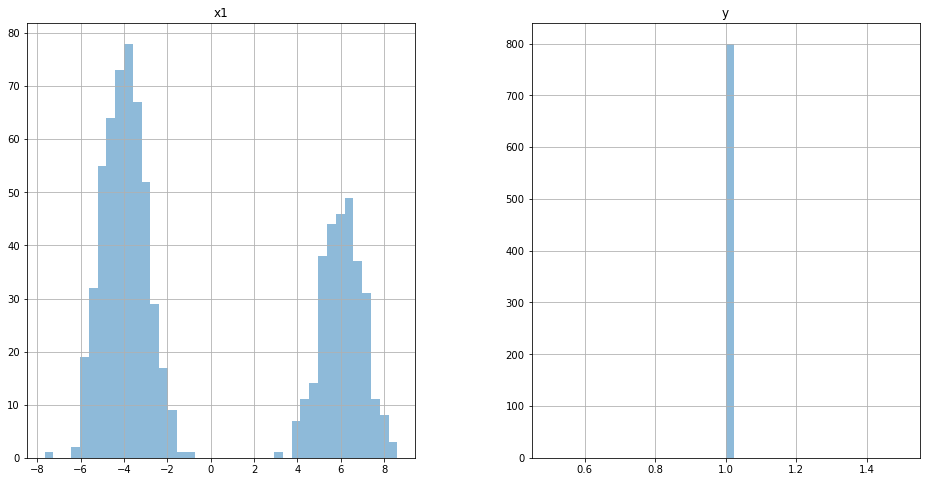

In [37]:
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,8))

training_set[['x1','y']][0:1000].groupby('y').hist(ax=ax[0],bins=20,alpha=0.5)
training_set[['x1','y']].groupby('y').hist(ax=ax[1],bins=40,alpha=0.5)

ax[0].set_title('first feature: histogram for each class - 1000 data points')
ax[1].set_title('first feature: histogram for each class - all data points')

ax[0].set_xlabel('x1')
ax[1].set_xlabel('x1')

ax[0].legend(['Class 0','Class 1'])
ax[1].legend(['Class 0','Class 1'])

plt.show()

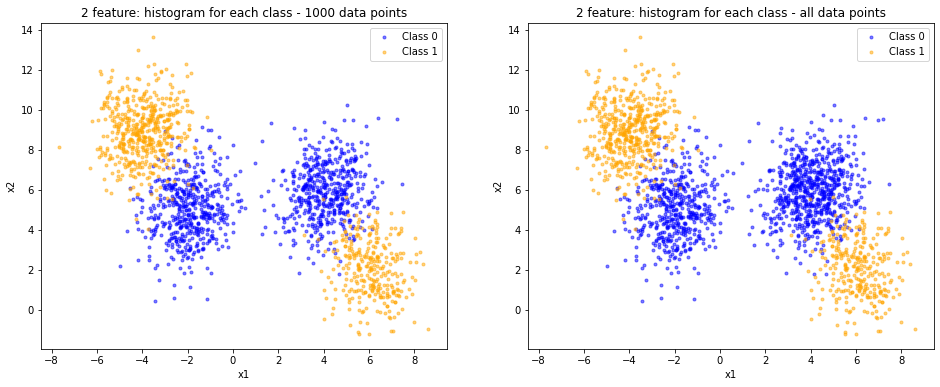

In [38]:
#### Your code here ####

class0 = training_set[training_set.y==0]
class1 = training_set[training_set.y==1]

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16,6))

ax[0].scatter(data=training_set[training_set.y==0][0:1000],x='x1',y='x2',marker='.',color='blue',alpha=0.5,label='Class 0')
ax[0].scatter(data=training_set[training_set.y==1][0:1000],x='x1',y='x2',marker='.',color='orange',alpha=0.5,label='Class 1')

ax[1].scatter(data=training_set[training_set.y==0],x='x1',y='x2',marker='.',color='blue',alpha=0.5,label='Class 0')
ax[1].scatter(data=training_set[training_set.y==1],x='x1',y='x2',marker='.',color='orange',alpha=0.5,label='Class 1')

ax[0].set_title('2 feature: histogram for each class - 1000 data points')
ax[1].set_title('2 feature: histogram for each class - all data points')

for ax_i in ax:
    ax_i.set_xlabel('x1')
    ax_i.set_ylabel('x2')
    ax_i.legend()
    
plt.show()


## Logistic Regression

(20 Points)

Implement the Logistic Regression algorithm that uses gradient descent for finding the optimal theta vector. 

Where:
$$
h_\theta(x) = \frac{1}{1 + e^{-\theta^T x}}
$$

$$
J(\theta)=\frac{1}{m} \sum_{d=1}^{m} - y^{(d)}ln(h_\theta(x^{(d)}) - (1 - y^{(d)})ln(1 - h_\theta(x^{(d)})
$$

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance after the fit function was executed

\* You can add more functions if you think this is necessary

Your model should also store a list of the costs that you've calculated in each iteration

In [39]:
class LogisticRegressionGD(object):
    """
    Logistic Regression Classifier using gradient descent.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    eps : float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random weight
      initialization.
    """

    def __init__(self, eta=0.00005, n_iter=10000, eps=0.000001, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.eps = eps
        self.random_state = random_state

    def fit(self, X, y):
        """
        Fit training data (the learning phase).
        Updating the theta vector in each iteration using gradient descent.
        Store the theta vector in an attribute of the LogisticRegressionGD object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        """

        # add a column with ones to the features
        self.m = len(y)
        X = np.hstack((X, np.ones((self.m, 1))))

        # Initialize theta
        self.theta = np.ones((X.shape[1], 1))

        # calculate costs and params
        self.gradient_descent(X, y, self.eta, self.n_iter)

    def predict(self, X):
        """Return the predicted class label"""
        X = np.hstack((X, np.ones((X.shape[0], 1))))
        predictions = np.round(self.sigmoid(X @ self.theta))
        return predictions

    def sigmoid(self, X):
        sigmoid_result = 1 / (1 + np.exp(-1*X))
        return sigmoid_result

    def compute_cost(self, X, y):
        h = self.sigmoid(X @ self.theta)
        epsilon = 1e-23
        cost = (1/self.m) * (((-y) @ (np.log(h + epsilon))) - ((1 - y) @ (np.log(1 - h + epsilon))))
        return cost

    def gradient_descent(self, X, y, learning_rate, iterations):
        self.cost_history = np.zeros((iterations, 1))
        self.cost_history[0] = self.compute_cost(X, y)

        for i in range(1,iterations):
            self.theta -= (learning_rate / self.m) * (X.T @ (self.sigmoid(X @ self.theta) - y[:,None]))
            self.cost_history[i] = self.compute_cost(X, y)
            if (self.cost_history[i-1] - self.cost_history[i]) < self.eps:
                break
                
    def get_accuracy(self,X,y):
        return np.mean(self.predict(X) == y)

## Cross Validation

(10 points)

Use 5-fold cross validation in order to find the best eps and eta params from the given lists.

Shuffle the training set before you split the data to the folds.

In [7]:
#### Your code here ####
etas = [0.05, 0.005, 0.0005, 0.00005, 0.000005]
epss = [0.01, 0.001, 0.0001, 0.00001, 0.000001]
num_folds = 5

np.random.seed(42)
training_inds_shuffled = np.arange(X_training.shape[0])
np.random.shuffle(training_inds_shuffled)
X_training_shuffled = X_training[training_inds_shuffled]
y_training_shuffled = y_training[training_inds_shuffled]
X_training_folds = np.split(X_training_shuffled, num_folds)
y_training_folds = np.split(y_training_shuffled, num_folds)
result_df = pd.DataFrame(index=epss, columns=etas)


for eta in etas:
    for eps in epss:
        split_ind = 0
        accuracies = []
        for fold_ind in range(num_folds):
            # split X to train and test for current fold
            x_train_fold = X_training_folds.copy()
            x_test_fold = X_training_folds[fold_ind]
            del x_train_fold[fold_ind]
            x_train_fold = np.concatenate(x_train_fold)

            # split y to train and test for current fold
            y_train_fold = y_training_folds.copy()
            y_test_fold = y_training_folds[fold_ind]
            del y_train_fold[fold_ind]
            y_train_fold = np.concatenate(y_train_fold)
            
            # train logistic regression model
            lr_obj = LogisticRegressionGD(eta=eta, eps=eps)
            lr_obj.fit(x_train_fold, y_train_fold)
            
            # predict and calculate accuracy
            predictions = lr_obj.predict(x_test_fold)
            accuracy = (predictions.ravel() == y_test_fold).sum() / y_test_fold.shape[0] * 100
            accuracies.append(accuracy)
        
        # calculate the mean accuracy of all folds and add it to the result df       
        mean_accuracy = np.mean(accuracies)
        result_df.loc[eps,eta] = mean_accuracy

result_df

,0.050000,0.005000,0.000500,0.000050,0.000005
0.010000,48.6,29.85,40.5,40.5,40.5
0.001000,51.35,51.25,29.6,40.5,40.5
0.000100,52.95,50.3,51.25,28.95,40.5
0.000010,64.7,52.8,50.25,28.95,40.55
0.000001,78.5,64.65,52.75,28.95,40.55


In [8]:
print("The best parameters are eta=0.05 and eps=0.000001")

The best parameters are eta=0.05 and eps=0.000001


## Normal distribution pdf

(5 Points)

Implement the normal distribution pdf 
$$
f(x;\mu,\sigma) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}\big{(}\frac{x-\mu}{\sigma}\big{)}^2}
$$
Write an efficient vectorized code

In [40]:
#### Your code here ####
# calc normal pdf    
def norm_pdf(data, mu, sigma):
    normal_dist = (1 / ((2*np.pi * sigma**2) ** 0.5)) *  np.exp((-(data-mu)**2) / (2 * (sigma**2)))
    return normal_dist

## Expectation Maximization

(20 Points)

Implement the Expectation Maximization algorithm for gaussian mixture model.

The class should hold the distribution params.

Use -log likelihood as the cost function:
$$
cost(x) = \sum_{d=1}^{m}-log(w * pdf(x; \mu, \sigma))
$$

\* The above is the cost of one gaussian. Think how to use the cost function for gaussian mixture.

Your class should contain the following functions:
1. init_params - initialize distribution params
1. expectation - calculating responsibilities
1. maximization - updating distribution params
1. fit - the learning function
1. get_dist_params - return the distribution params

\* You can add more functions if you think this is necessary

Don't change the eps params (eps=0.01)

When you need to calculate the pdf of a normal distribution use the function `norm_pdf` that you implemented above.

In [41]:
class EM(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    n_iter : int
      Passes over the training dataset in the EM proccess
    eps: float
      minimal change in the cost to declare convergence
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1, n_iter=1000, eps=0.01):
        self.k = k
        self.n_iter = n_iter
        self.eps = eps

    # initial guesses for parameters
    def init_params(self, data):
        """
        Initialize distribution params
        """
        self.w = np.ones(self.k) / self.k
        self.mu = np.array([(i / self.k) * np.mean(data) for i in range(1, self.k + 1)])
        self.std = np.array([(i / self.k) * np.std(data) for i in range(1, self.k + 1)])

    def expectation(self, data):
        """
        E step - calculating responsibilities
        """
        likelihood = np.multiply(np.hstack(norm_pdf(data, self.mu[i], self.std[i])[:, np.newaxis] for i in range(len(self.mu))), self.w)
        
        responsibilities = likelihood / likelihood.sum(axis=1)[:,None]
        return responsibilities,likelihood

    def maximization(self, data):
        """
        M step - updating distribution params
        """

        w = self.responsibilities.mean(axis=0)
        mu = (self.responsibilities.T @ data[:,None] / (self.w[:,None] * data.shape[0])).ravel()
        std = np.sqrt(np.mean(np.multiply(self.responsibilities, np.square(np.array(data)[:, np.newaxis] - self.mu)), axis=0) / self.w)
        
        return w, mu, std

    def fit(self, data):
        """
        Fit training data (the learning phase).
        Use init_params and then expectation and maximization function in order to find params
        for the distribution.
        Store the params in attributes of the EM object.
        Stop the function when the difference between the previous cost and the current is less than eps
        or when you reach n_iter.
        """
        self.init_params(data)
        
        self.log_likelihood = -np.inf
        
        # stop (ll.inf) or stop(diff<eps) or n_itr
        for _ in range(self.n_iter):
            self.responsibilities,likelihood = self.expectation(data)
            log_likelihood = -1 * np.sum(np.log(likelihood.sum(axis=1)))
            
            old_log_likelihood = self.log_likelihood
            self.log_likelihood = -1*np.sum(np.log(likelihood))
            
            if np.isinf(self.log_likelihood) or (np.abs(self.log_likelihood-old_log_likelihood) <= self.eps):
                break
            
            new_w, new_mu, new_std = self.maximization(data)
            self.w = new_w
            self.mu = new_mu
            self.std = new_std
            
            

    def get_dist_params(self):
        return self.w, self.mu, self.std


In [ ]:
em = EM(k=2)
em.fit(X_test[: , 0])
em.get_dist_params()

## Naive Bayes

(20 Points)

Implement the Naive Bayes algorithm.

For calculating the likelihood use the EM algorithm that you implemented above to find the distribution params. With these params you can calculate the likelihood probability.

Calculate the prior probability directly from the training set.

Your class should contain the following functions:
1. fit - the learning function
1. predict - the function for predicting an instance (or instances) after the fit function was executed

\* You can add more functions if you think this is necessary


In [42]:
class NaiveBayesGaussian(object):
    """
    Naive Bayes Classifier using Gauusian Mixture Model (EM) for calculating the likelihood.

    Parameters
    ------------
    k : int
      Number of gaussians in each dimension
    random_state : int
      Random number generator seed for random params initialization.
    """

    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        """
        Fit training data.

        Parameters
        ----------
        X : array-like, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.
        """

        # get prior of the two classes
        self.class_0_prior = self.get_prior(y, 0)
        self.class_1_prior = 1 - self.class_0_prior

        # train EM on class 0 feature 0
        class_0_inds = y == 0
        x_class_0_f_0 = X[class_0_inds,0]
        self.em_model_class_0_f_0 = EM(k=self.k)
        self.em_model_class_0_f_0.fit(x_class_0_f_0)

        # train EM on class 0 feature 1
        x_class_0_f_1 = X[class_0_inds,1]
        self.em_model_class_0_f_1 = EM(k=self.k)
        self.em_model_class_0_f_1.fit(x_class_0_f_1)

        # train EM on class 1 feature 0
        class_1_inds = y == 1
        x_class_1_f_0 = X[class_1_inds,0]
        self.em_model_class_1_f_0 = EM(k=self.k)
        self.em_model_class_1_f_0.fit(x_class_1_f_0)

        # train EM on class 1 feature 1
        x_class_1_f_1 = X[class_1_inds,1]
        self.em_model_class_1_f_1 = EM(k=self.k)
        self.em_model_class_1_f_1.fit(x_class_1_f_1)

    def predict(self, X):
        """Return the predicted class label"""

        likelihood_class_0_feature_0 = np.max(self.em_model_class_0_f_0.expectation(X[:,0])[1], axis=1)
        likelihood_class_0_feature_1 = np.max(self.em_model_class_0_f_1.expectation(X[:, 1])[1], axis=1)

        likelihood_class_1_feature_0 = np.max(self.em_model_class_1_f_0.expectation(X[:, 0])[1], axis=1)
        likelihood_class_1_feature_1 = np.max(self.em_model_class_1_f_1.expectation(X[:, 1])[1], axis=1)

        posterior_class_0 = self.class_0_prior * likelihood_class_0_feature_0 * likelihood_class_0_feature_1
        posterior_class_1 = self.class_1_prior * likelihood_class_1_feature_0 * likelihood_class_1_feature_1

        predictions = np.zeros_like(posterior_class_0)
        greater_prob_1_inds = posterior_class_1 > posterior_class_0
        predictions[greater_prob_1_inds] = 1
        return predictions


    def get_prior(self, y, class_value):
        prior_prob = (y == class_value).sum() / len(y)
        return prior_prob


## Model evaluation

(10 points)

In this section you will build 2 models and fit them to 2 datasets

First 1000 training points and first 500 test points:
1. Use the first 1000 points from the training set (take the first original 1000 points - before the shuffle) and the first 500 points from the test set.
1. Fit Logistic Regression model with the best params you found earlier.
1. Fit Naive Bayes model. Remember that you need to select the number of gaussians in the EM.
1. Print the training and test accuracies for each model.
1. Use the `plot_decision_regions` function to plot the decision boundaries for each model (for this you need to use the training set as the input)
1. Plot the cost Vs the iteration number for the Logistic Regression model

Use all the training set points:
1. Repeat sections 2-6 for all the training set points

### Evaluation on part of the data

In [43]:
#### Your code here ####
# take first 1000 records from training and first 500 records from test set
x_training_1000_samples = X_training[:1000,:]
y_training_1000_samples = y_training[:1000]

x_test_500_samples = X_test[:500, :]
y_test_500_samples = y_test[:500]

# fit logistic regression model
best_eta = 0.05
best_eps = 0.000001
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(x_training_1000_samples, y_training_1000_samples)

# fit naive bayes model
nb_model = NaiveBayesGaussian(k=1)
nb_model.fit(x_training_1000_samples, y_training_1000_samples)

# accuracy for each model
lr_predictions = lr_model.predict(x_test_500_samples)
lr_accuracy = (lr_predictions.ravel() == y_test_500_samples).sum() / len(y_test_500_samples) * 100
nb_predictions = nb_model.predict(x_test_500_samples)
nb_accuracy = (nb_predictions.ravel() == y_test_500_samples).sum() / len(y_test_500_samples) * 100
print(f"The accuracy of the logistic regression model for the smaller amount of data is {np.round(lr_accuracy,2)}% ")
print(f"The accuracy of the naive bayes model for the smaller amount of data is {np.round(nb_accuracy,2)}% ")


The accuracy of the logistic regression model for the smaller amount of data is 93.8% 
The accuracy of the naive bayes model for the smaller amount of data is 94.2% 


Text(0.5, 1.0, 'Decision Boundary of Logistic Regression for Small amount of Data')

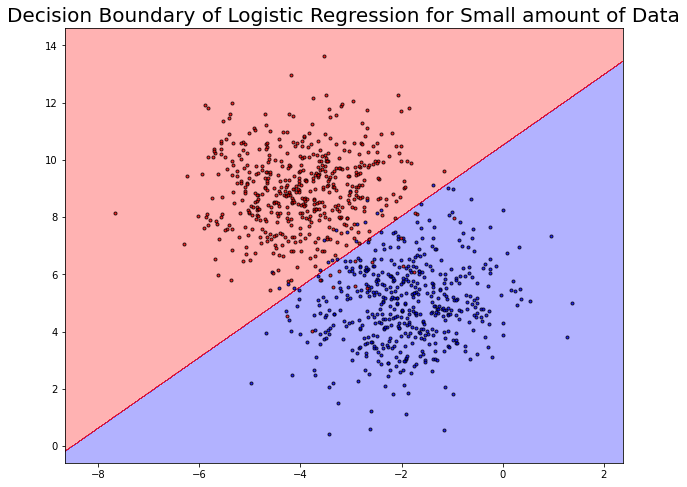

In [44]:
# decision boundary of logistic regression on part of the data
plot_decision_regions(x_training_1000_samples, y_training_1000_samples, lr_model, resolution=0.01)
plt.title("Decision Boundary of Logistic Regression for Small amount of Data", fontsize=20)


Text(0.5, 1.0, 'Decision Boundary of Naive Bayes on Small Amount of Data')

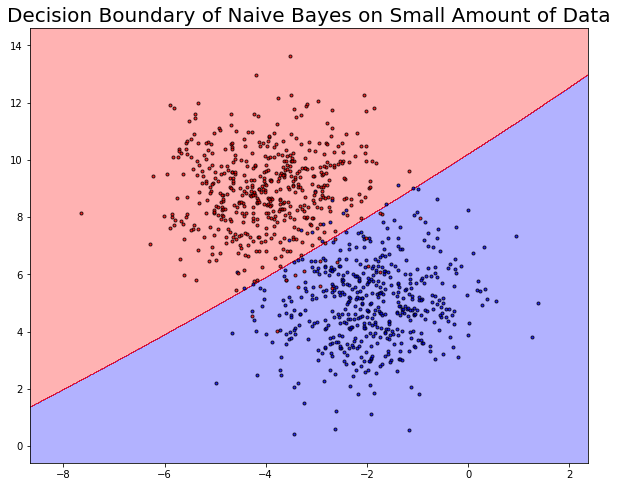

In [45]:
# decision boanndary of naive bayes on part of the data
plot_decision_regions(x_training_1000_samples, y_training_1000_samples, nb_model, resolution=0.01)
plt.title("Decision Boundary of Naive Bayes on Small Amount of Data", fontsize=20)


Text(0, 0.5, 'Cost')

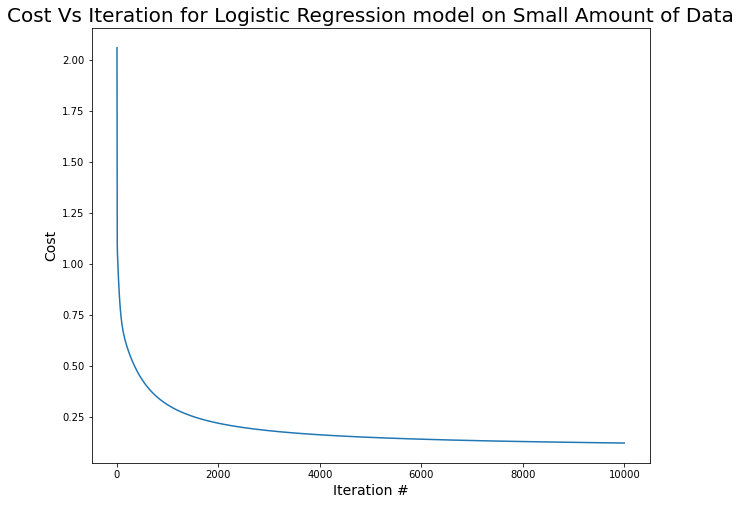

In [46]:
# plot cost vs the iteration for the logistic regression model
plt.plot(lr_model.cost_history)
plt.title("Cost Vs Iteration for Logistic Regression model on Small Amount of Data", fontsize=20)
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Cost", fontsize=14)


### Evaluation on all data

In [47]:
# fit logistic regression model
lr_model = LogisticRegressionGD(eta=best_eta, eps=best_eps)
lr_model.fit(X_training, y_training)

# fit naive bayes model
nb_model = NaiveBayesGaussian(k=2)
nb_model.fit(X_training, y_training)

# accuracy for each model
lr_predictions = lr_model.predict(X_test)
lr_accuracy = (lr_predictions.ravel() == y_test).sum() / len(y_test) * 100
nb_predictions = nb_model.predict(X_test)
nb_accuracy = (nb_predictions.ravel() == y_test).sum() / len(y_test) * 100
print(f"The accuracy of the logistic regression model for all data is {lr_accuracy}% ")
print(f"The accuracy of the naive bayes model for all data is {nb_accuracy}% ")


The accuracy of the logistic regression model for all data is 79.2% 
The accuracy of the naive bayes model for all data is 89.9% 


Text(0.5, 1.0, 'Decision Boundary of Logistic Regression for all Data')

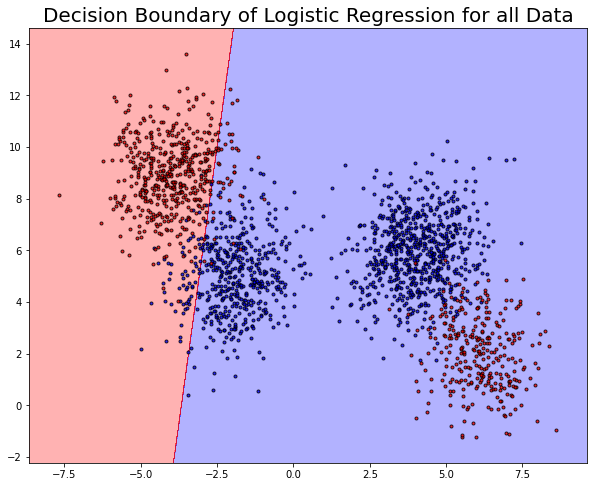

In [48]:
# decision boundary of logistic regression on all data
plot_decision_regions(X_training, y_training, lr_model, resolution=0.01)
plt.title("Decision Boundary of Logistic Regression for all Data", fontsize=20)


Text(0.5, 1.0, 'Decision Boundary of Naive Bayes for all Data')

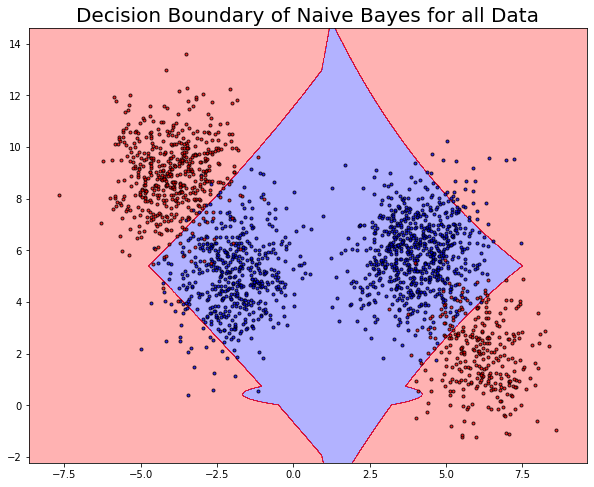

In [49]:
# decision boundary of naive bayes on all data
plot_decision_regions(X_training, y_training, nb_model, resolution=0.01)
plt.title("Decision Boundary of Naive Bayes for all Data", fontsize=20)


Text(0, 0.5, 'Cost')

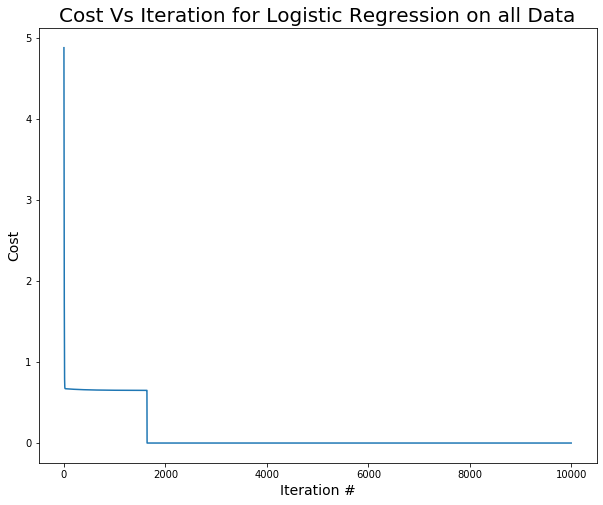

In [19]:
# plot cost vs the iteration for the logistic regression model
plt.plot(lr_model.cost_history)
plt.title("Cost Vs Iteration for Logistic Regression on all Data", fontsize=20)
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Cost", fontsize=14)


## Open question

(7 points) 

Will Full Bayes get better results comparing to Naive Bayes on the following dataset? Explain. 

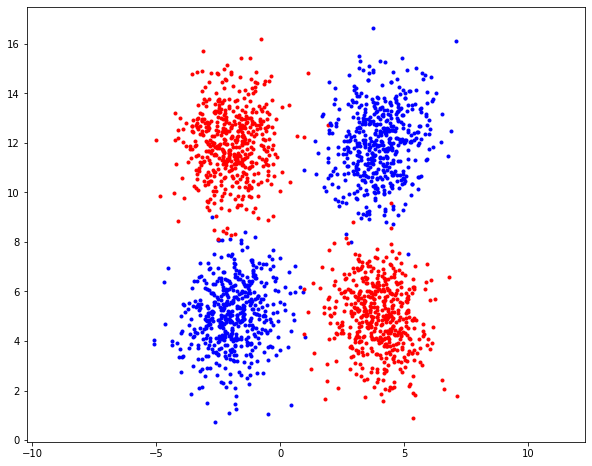

In [20]:
mean = [[-2,5], [-2, 12], [4, 12], [4, 5]]
cov = [[[1,0.2],[0.2,2]], [[1,0],[0,2]], [[1,0.2],[0.2,2]], [[1,-0.2],[-0.2,2]]]
x1 = []
x2 = []
y = []
size = [500, 500, 500, 500]
c = ['b', 'r']

for i in range(4):
    xx1,xx2 = np.random.multivariate_normal(mean[i],cov[i],size[i]).T
    x1.extend(xx1)
    x2.extend(xx2)
    y.extend([i%2] * size[i])
    plt.scatter(xx1,xx2, marker='.', c=c[i%2])

plt.axis('equal')
plt.show()

#### Your answer here ####


**Yes,** the full bayes will get better results comparing to naive bayes on the dataset above.   

In order to calculate the posterior probabilities more easily,  
the naive bayes makes the assumption that features are independent from each other,  
meaning that the value of a feature on a given class is independent of the values of other features.     

Strictly by numerical calculations,   
the covariances are small relative to the variances of each variable (e.g. by taking the determinant of the covariance matrix).  
However, this only account for strong linear dependence between variables and may not reflect strong nonlinear dependencies. 

As we can see, in this example:  
the variables are highly dependent! especially given the class - Knowing the class and value of one feature, strongly affects the distribution of the other feature.  
So the two features are correlated within the two classes and hence the assumption that the features are independent doesn't hold.   

**Therefore, the full bayes will get better results on this dataset!**